In [1]:
import pandas as pd
import numpy as np


In [2]:
def preprocess_features(runs_df):
    # convert some int columns to labels
    runs = runs_df.assign(leg_id=runs_df.leg_nro.astype(str))
    runs = runs.assign(num_runs=runs.num_runs.astype(str))
    runs = runs.drop(["leg_nro", "year", "team"], axis=1)
    
    # A columns that contains most poular first names or NA
    runs["first_name"] = runs.name.str.split(" ", expand=True).iloc[:,0]
    runs["first_name"].describe()
    counts = runs["first_name"].value_counts()
    top_counts = counts[counts > 20]

    runs["tfn"] = runs["first_name"]

    def top_name(first_name): 
        if first_name in top_counts:
            return first_name
        else:
            return  "NA"

    runs["tfn"] = runs.apply(lambda run: top_name(run["first_name"]), axis=1)
    display(top_counts.describe())
    
    # Explode categories to dummy columns
    features = pd.get_dummies(runs[["tfn", "leg_id", "num_runs"]], sparse=True)
    # allow linear regression to fit non-linear terms
    features["team_id_log2"] = np.log2(runs.team_id)
    features["team_id_log10"] = np.log10(runs.team_id)
    features["team_id_square"] = np.square(runs.team_id)
    
    features.insert(0, "team_id", runs["team_id"])

    import json
    with open(f"data/preprocess_priors_feature_columns.json", 'w') as outfile:
        json.dump(features.columns.tolist(), outfile)

    x = features.values
    #x = features[["team_id_log10", "team_id_log2", "leg_id_1", "leg_id_2", "leg_id_3", "leg_id_4", "leg_id_5", "leg_id_6", "leg_id_7"]].values # Poista tää.
    y = np.log(runs.pace.values)
    y = y.reshape(len(y), 1)
    
    display(x.shape)
    display(y.shape)

    return (features, x, y)

In [3]:
in_file_name = 'data/runs_ju.tsv'
runs_df = pd.read_csv(in_file_name, delimiter="\t")

(features, x, y) = preprocess_features(runs_df)


count     452.000000
mean      143.420354
std       236.130062
min        21.000000
25%        31.000000
50%        54.000000
75%       131.000000
max      1787.000000
Name: first_name, dtype: float64

(76545, 474)

(76545, 1)

In [4]:
features.head(10)

,team_id,tfn_,tfn_NA,tfn_aapo,tfn_aarne,tfn_aarno,tfn_aaro,tfn_aatu,tfn_adam,tfn_ahti,...,num_runs_2,num_runs_3,num_runs_4,num_runs_5,num_runs_6,num_runs_7,num_runs_8,team_id_log2,team_id_log10,team_id_square
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1.000000,0.301030,4
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,4.000000,1.204120,256
2,143,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,7.159871,2.155336,20449
3,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,3.584963,1.079181,144
4,37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,5.209453,1.568202,1369
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1.000000,0.301030,4
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.000000,0.000000,1
7,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,3.169925,0.954243,81
8,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,3.584963,1.079181,144
9,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,4.392317,1.322219,441


In [5]:
features.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 76545 entries, 0 to 76544
Columns: 474 entries, team_id to team_id_square
dtypes: Sparse[float64, nan](2), Sparse[int64, nan](2), Sparse[uint8, 0](470)
memory usage: 3.4 MB


In [6]:
import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=2019)

In [8]:
def fit_and_test_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train.ravel())
    y_pred = np.exp(model.predict(x_test))
    print("Mean squared error: %.3f" % mean_squared_error(np.exp(y_test), y_pred))
    print('Explained variance score: %.3f' % r2_score(np.exp(y_test), y_pred))

In [9]:
%%time
linear = linear_model.LinearRegression()
fit_and_test_model(linear, x_train, x_test, y_train, y_test)

Mean squared error: 5.334
Explained variance score: 0.388
CPU times: user 6.56 s, sys: 588 ms, total: 7.15 s
Wall time: 2.43 s


In [10]:
%%time

gbr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=3100, random_state=0, verbose=1)

fit_and_test_model(gbr, x_train, x_test, y_train, y_test)

#print(f"feature_importances_: {gbr.feature_importances_}")
#gbr_features = pd.DataFrame({'feature':first_names.columns, 'importance': gbr.feature_importances_})
#gbr_features['feature'] = gbr_features['feature'].str.replace('top_first_name_','')
#display(gbr_features.sort_values(by="importance", ascending=False))

      Iter       Train Loss   Remaining Time 
         1           0.0637           64.06m
         2           0.0592           63.75m
         3           0.0556           63.85m
         4           0.0525           64.06m
         5           0.0501           64.02m
         6           0.0480           64.12m
         7           0.0463           64.09m
         8           0.0449           64.03m
         9           0.0437           64.13m
        10           0.0427           64.13m
        20           0.0384           64.23m
        30           0.0373           63.37m
        40           0.0368           61.66m
        50           0.0365           60.34m
        60           0.0363           58.74m
        70           0.0362           58.18m
        80           0.0361           57.66m
        90           0.0360           57.21m
       100           0.0359           56.77m
       200           0.0351           53.85m
       300           0.0346           51.45m
       40

In [11]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'
os.environ['OMP_NUM_THREADS'] = '12'

import pymc3 as pm
import pmlearn
from pmlearn.linear_model import LinearRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))


Running on pymc-learn v0.0.1.rc3


In [12]:
pmlearn_linear = LinearRegression()
fit_and_test_model(pmlearn_linear, pd.DataFrame(data=x_train), pd.DataFrame(x_test), y_train, y_test)

Average Loss = 3.948e+05: 100%|██████████| 200000/200000 [47:03:11<00:00,  1.23it/s]       
Finished [100%]: Average Loss = 3.9492e+05
100%|██████████| 2000/2000 [02:41<00:00, 12.35it/s]


Mean squared error: 453728512.872
Explained variance score: -52021729.157


In [13]:
pmlearn_preds = pmlearn_linear.predict(pd.DataFrame(x_test), return_std=True)

100%|██████████| 2000/2000 [02:37<00:00, 12.83it/s]


In [14]:
np.exp(pmlearn_preds[0]).shape

pd.DataFrame({
    'mean':np.exp(pmlearn_preds[0]), 
    'std':np.exp(pmlearn_preds[1]), 
    'true':np.exp(y_test).ravel()
})

,mean,std,true
0,1.944819e+00,1.050021e+80,7.944
1,1.413418e-03,3.740332e+79,9.944
2,2.756157e-05,9.976947e+79,12.044
3,2.879091e-05,2.448147e+78,10.301
4,7.305510e+01,2.509136e+80,7.181
5,4.541642e-01,2.316203e+77,8.863
6,1.445049e-01,1.110164e+78,8.437
7,1.247973e-01,1.785718e+80,8.730
8,6.067888e-02,6.566943e+79,10.509
9,1.879137e-10,1.081157e+79,12.098


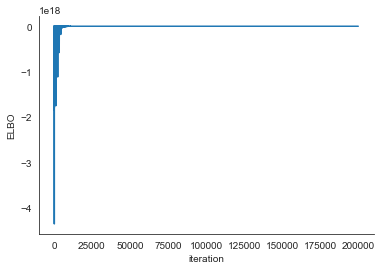

In [15]:
pmlearn_linear.plot_elbo()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x150cbe978>,
      dtype=object)

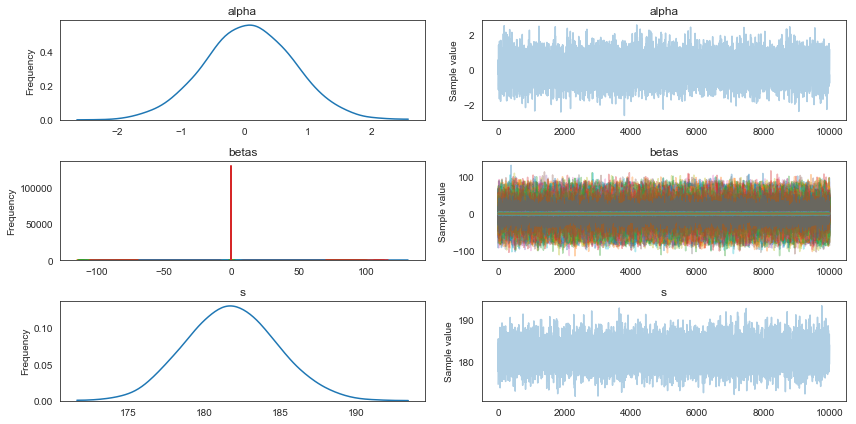

In [16]:
pm.traceplot(pmlearn_linear.trace)

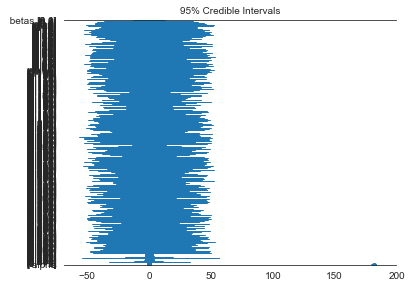

In [17]:
pm.forestplot(pmlearn_linear.trace, varnames=["betas", "alpha", "s"]);

In [18]:
pm.summary(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
betas__0_0,0.003310,0.003284,3.015044e-05,-0.003316,0.009558
betas__0_1,0.265397,18.239151,1.809066e-01,-36.185678,35.193612
betas__0_2,0.124731,1.706467,1.555576e-02,-3.287029,3.373461
betas__0_3,0.005385,14.727635,1.347031e-01,-29.410843,28.324075
betas__0_4,-0.363345,21.017340,2.285573e-01,-42.044497,39.813663
betas__0_5,0.212629,22.623933,2.226170e-01,-43.456085,44.071905
betas__0_6,0.355364,19.987333,1.696264e-01,-37.893633,39.426535
betas__0_7,0.288669,22.970902,2.166000e-01,-43.805864,46.185769
betas__0_8,-0.261829,22.639031,2.158650e-01,-43.543607,45.159665
betas__0_9,0.091202,21.342156,2.436598e-01,-41.287534,41.771143


/Users/oskari/.virtualenvs/jukola-xml-model-PGRmw6ze/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


array([<matplotlib.axes._subplots.AxesSubplot object at 0x17c0df1d0>,
      dtype=object)

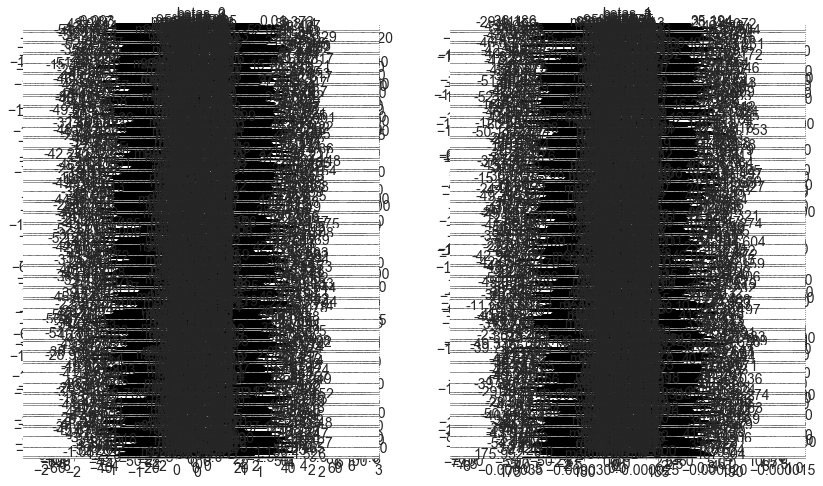

In [19]:
pm.plot_posterior(pmlearn_linear.trace, varnames=["betas", "alpha", "s"],
                 figsize = [14, 8])

In [20]:
pm.gelman_rubin(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])

ValueError: Gelman-Rubin diagnostic requires multiple chains of the same length.